In [4]:
from read_data import *
from hyper import *
from alignment import *
from copy import *
from datasets.preprecossing import *
import rpy2

folder_path = './datas/719/'
pcanum = 20

In [2]:
datas.obs

NameError: name 'datas' is not defined

In [3]:
datas = sc.read_h5ad("./datas/nature/151507_preprocessed.h5")
count_sub = datas.to_df()
xy_coords = datas.obs[['imagerow',"imagecol"]]
xy_coords.to_csv(folder_path+"xy.csv")
datas.obs.to_csv(folder_path+'meta_data.csv');
count_sub.T.to_csv(folder_path+"gene.csv")

In [4]:
# robjects.r("load(paste0('./datas/pca/DLPFC/LIBD_sample1.RData'))")
from rpy2.robjects.packages import importr
import rpy2.robjects as robjects

Spatialpc  = importr('SpatialPCA')
ggplot2 = importr('ggplot2')
matrix = importr('Matrix')
robjects.r("xy_coords <- read.csv('xy.csv',row.names='X')")
robjects.r("xy_coords=as.matrix(xy_coords)")
robjects.r("count_temp <- read.csv('gene.csv',row.names='X')")
robjects.r('my_matrix <- do.call(cbind, count_temp)')
robjects.r('my_sparse_matrix <- Matrix(my_matrix, sparse = TRUE)')
robjects.r('count_sub <- as(my_sparse_matrix, "dgCMatrix")')
robjects.r('rownames(count_sub) <- rownames(count_temp)')
robjects.r("rownames(xy_coords) = colnames(count_sub)");
robjects.r('LIBD = CreateSpatialPCAObject(counts=count_sub, location=xy_coords, project = "SpatialPCA",gene.type="spatial",sparkversion="spark",numCores_spark=5,gene.number=3000, customGenelist=NULL,min.loctions = 20, min.features=20)')
robjects.r('LIBD = SpatialPCA_buildKernel(LIBD, kerneltype="gaussian", bandwidthtype="SJ",bandwidth.set.by.user=NULL)')
robjects.r('LIBD = SpatialPCA_EstimateLoading(LIBD,fast=FALSE,SpatialPCnum={})'.format(pcanum))
robjects.r('LIBD = SpatialPCA_SpatialPCs(LIBD, fast=FALSE)')
robjects.r('write.csv(as.data.frame(LIBD@SpatialPCs), file = "{}")'.format(folder_path + "pca.csv"))


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    ## Use SCTransform function in Seurat to normalize data. 


R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Variance stabilizing transformation of count matrix of size 9948 by 4220

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 2000 genes, 4220 cells



  |======================================================================| 100%


R[write to console]: Found 37 outliers - those will be ignored in fitting/regularization step


R[write to console]: Second step: Get residuals using fitted parameters for 9948 genes



  |======================================================================| 100%


R[write to console]: Computing corrected count matrix for 9948 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 47.03126 secs

R[write to console]: Determine variable features

R[write to console]: Place corrected count matrix in counts slot

R[write to console]: Centering data matrix

  |                                                                            
  |                                                                      |   0%
  |                                                                            
  |=====                                                                 |   7%
  |                                                                            
  |==========                                                            |  14%
  |                                                                            
  |===============                                                       |  21%
  |                                                                         

## Use spark.test function in SPARK package to select spatially variable genes. 
## ===== SPARK INPUT INFORMATION ==== 
## number of total samples:  4220 
## number of total features:  3969 
## number of adjusted covariates:  0 
# fitting normalized count-based spatial model under the null hypothesis ... 
## testing Gaussian kernel: 1...
## testing Periodic kernel: 1...
## testing Gaussian kernel: 2...
## testing Periodic kernel: 2...
## testing Gaussian kernel: 3...
## testing Periodic kernel: 3...
## testing Gaussian kernel: 4...
## testing Periodic kernel: 4...
## testing Gaussian kernel: 5...
## testing Periodic kernel: 5...
## Identified  1290  spatial genes through spark.test function. 
The  number of significant spatial genes is less than the specified number of spatial genes. 
## Using  1290  significant spatially variable genes. 
## Selected kernel type is:  gaussian  
## The bandwidth is:  0.0396964277485742  
## Calculating kernel matrix
## Finished calculating kernel matrix

In [5]:
adata1 = pd.read_csv(folder_path+"pca.csv")
adata1 = adata1.set_index(adata1.columns[0]).T
adata1.index = adata1.index.str.replace('.', '-')
adata1 = anndata.AnnData(adata1)

cell_meta = pd.read_csv(folder_path+"meta_data.csv")
cell_meta = cell_meta.set_index(cell_meta.columns[0])
adata1.obs = cell_meta
adata1.obsm['X_pca'] = adata1.to_df()
# # adata1.obs['celltype'] = cell_meta.values




/var/folders/bm/69jvgsdj3rxch558kx9yp9y00000gn/T/ipykernel_1281/953224956.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  adata1.index = adata1.index.str.replace('.', '-')
/var/folders/bm/69jvgsdj3rxch558kx9yp9y00000gn/T/ipykernel_1281/953224956.py:4: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata1 = anndata.AnnData(adata1)
/Users/dongjiajie/opt/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


./datas/719/datas.data length:4220
Generating all pairs subset


100%|██████████| 1563/1563 [01:11<00:00, 21.99ex/s, loss=0.924154]


	 Epoch 9 | average train loss: 1.025064
Optimization finished.


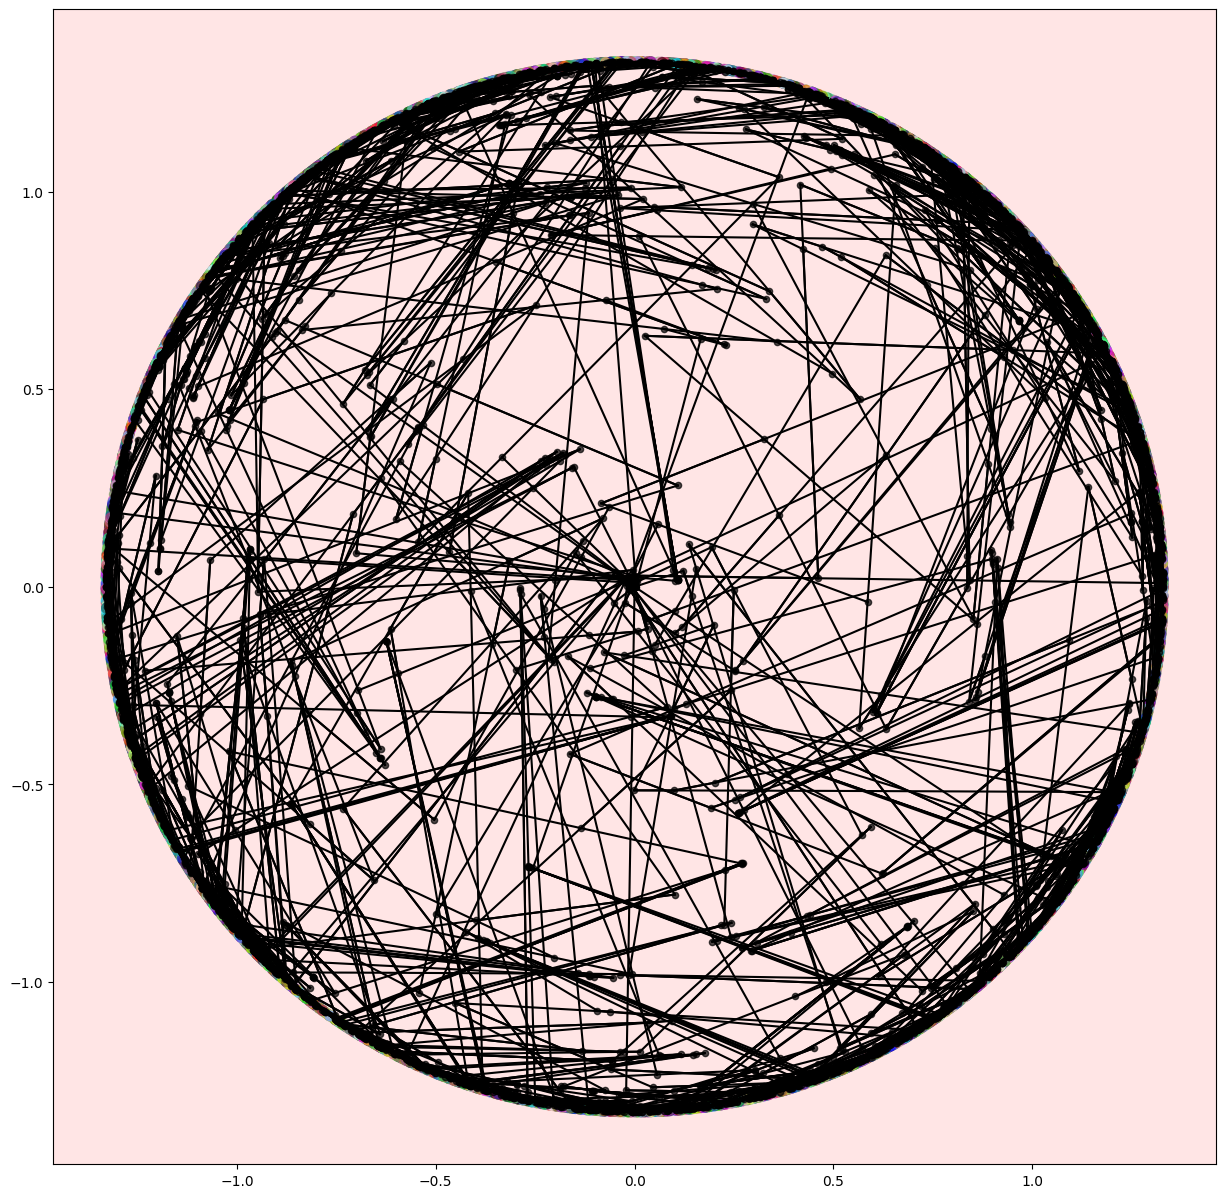

In [16]:
pd.DataFrame(adata1.X).to_csv(folder_path+"datas.data",header=None)
pd.DataFrame(adata1.X).to_csv(folder_path+"datas.csv")

get_Hyper_tree(folder_path+'datas.data',1,20+1,0,10,model_path=None,save_path=folder_path,c=0)


In [6]:
adata1.to_df()

Unnamed: 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
Unnamed: 0,,,,,,,,,,,,,,,,,,,,
AAACAACGAATAGTTC-1,-1.742179,-0.050372,0.172844,2.192439,-0.777553,-4.132174,1.636083,1.739748,0.270036,-2.573790,-0.470066,-0.515245,-0.126150,-0.132189,0.190587,0.518257,1.745402,1.127537,-1.012781,0.484063
AAACAAGTATCTCCCA-1,4.208591,-0.188750,-0.850747,-0.732998,1.336927,1.366941,1.130777,-0.353206,-0.060463,0.475084,0.766953,-0.065829,0.621593,0.378397,-0.311984,0.169382,0.094349,0.323343,0.355282,0.735483
AAACAATCTACTAGCA-1,-8.122478,8.238339,-2.817448,-3.844993,-1.577289,-0.367433,-0.526728,0.374770,1.681579,1.073618,2.758376,0.380476,0.153697,0.705445,-0.267159,-0.631223,-0.152607,0.123091,-0.202371,0.939734
AAACACCAATAACTGC-1,-15.563433,-8.868979,5.220857,-4.435772,2.248321,1.530303,-0.325219,-1.786930,-0.099736,-0.156798,-0.764029,1.235195,0.907501,-0.273418,0.470980,-0.115996,1.055449,-0.224519,2.311397,0.503695
AAACAGCTTTCAGAAG-1,2.585480,-1.649134,-0.027134,-0.087575,-3.085096,-1.255844,1.381870,-1.967390,-3.015521,2.926177,0.604160,0.950124,-0.354756,-0.858949,1.690995,-0.863722,-0.497408,0.504896,0.390848,-1.036021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGTTGTGTGTCAAGA-1,3.602209,2.274316,0.859793,-1.887574,1.028837,0.160600,-0.779891,0.649933,0.058348,-0.661194,-0.129109,-0.218892,-0.683292,0.442794,0.489751,0.162806,0.290944,0.404469,0.804577,-0.261684
TTGTTTCACATCCAGG-1,-0.240509,-3.556936,1.898851,-0.375175,-2.388757,0.033545,-0.173732,1.782997,-1.256519,1.225309,-0.382412,-1.119076,-1.028756,0.334160,0.193641,0.333617,-0.223856,0.283033,0.393235,0.034724
TTGTTTCATTAGTCTA-1,-10.261098,-7.747452,1.222923,2.723484,2.947516,-2.285964,-0.099366,1.651121,-2.607931,-0.302745,1.238690,-2.321925,2.557547,2.055927,-2.068038,-1.114067,-1.470836,1.470817,-1.015627,1.710811


In [7]:
sc.pp.highly_variable_genes(adata1,n_top_genes=2000)
adata1.var['highly_variable']
adata = adata1[:, adata1.var['highly_variable']]
adata

View of AnnData object with n_obs × n_vars = 4220 × 20
    obs: 'in_tissue', 'array_row', 'array_col', 'imagerow', 'imagecol', 'sum_umi', 'sum_gene', 'subject', 'position', 'replicate', 'discard', 'cell_count', 'layer_guess', 'layer_guess_reordered', 'layer_guess_reordered_short', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'n_counts'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg'
    obsm: 'X_pca'

In [8]:
adata1.raw = adata1

sc.pp.neighbors(adata1,
                n_neighbors=10,
                use_rep='X_pca',
                random_state=1234
                )
sc.tl.diffmap(adata1,random_state=1234)
sc.tl.umap(adata1,random_state=1234)
sc.tl.leiden(adata1,random_state=1234,resolution = 0.5)
sc.tl.paga(adata1, groups='leiden')


In [9]:
set_initial_condition(adata1);


In [10]:
inter_gene = sort_data(adata1,adata1)

20 genes are used to calculate cost of tree alignment.



In [11]:
calculate_cluster_centroid_for_genes

<function datasets.preprecossing.calculate_cluster_centroid_for_genes(adata, gene_list, save_path='./')>

In [12]:
tmp1 = calculate_cluster_centroid_for_genes(adata1,inter_gene,folder_path)
tmp1

Unnamed: 0,3,15,19,18,20,11,12,17,13,10,1,8,2,9,7,4,14,5,16,6
0,2.293981,-0.235488,0.396009,-0.003164,0.169214,-0.028950,-0.001542,0.092659,0.003213,0.023851,3.561030,0.454017,2.748841,-0.511378,-0.334561,-0.594649,0.172078,0.418282,-0.035094,-0.179187
1,-1.936229,0.661202,-0.360804,-0.192247,0.029846,-0.376653,0.361206,-0.204624,0.173495,0.048990,2.632780,0.366353,-1.811490,0.069354,-1.226792,-1.815600,-0.017411,1.283048,-0.093221,-1.330971
2,-1.935983,0.167036,-0.125852,-0.035088,0.066331,-0.755816,0.294315,0.017408,-0.073510,0.020778,-5.731224,-0.226903,5.358453,-0.605033,0.163447,0.287393,0.300639,-0.285602,-0.184523,1.210255
3,2.051968,0.042507,0.047162,0.189116,0.038378,-0.238120,-0.478473,0.120811,0.081146,0.782735,-6.748460,0.004555,-4.977643,-0.843451,-0.289046,-0.760641,0.489884,0.218557,0.127769,-0.271255
4,-1.404566,0.258727,0.475571,-0.025594,-0.002075,1.386804,-0.000855,0.089320,0.094738,-0.138236,-5.199153,1.331605,4.490820,0.510406,0.014336,-0.927808,-0.213218,-1.113093,0.066404,-0.805423
5,0.999948,-0.245885,-0.063431,0.372790,-0.303618,-0.841863,-0.122853,0.275506,0.365753,0.455538,1.314512,0.356909,2.297382,0.147503,-0.199397,1.876997,-1.028603,1.435984,0.130150,0.608001
6,-0.814287,0.528282,-0.024901,0.093582,0.166852,-0.005252,-0.390807,0.271760,-0.381213,-0.311412,2.298734,0.437895,-3.744255,-0.563961,-0.728712,-0.029124,-0.045018,-1.482290,0.666238,1.278809
7,-0.840742,0.194237,0.123641,0.778323,0.047726,-0.273101,0.088360,0.092964,0.078392,-0.402306,2.215904,-1.598003,-1.663135,0.076963,1.339420,-0.619728,0.060458,-1.612785,-0.089593,-1.022185
8,1.061429,-0.325227,-0.063193,-0.027433,0.335309,0.261947,0.314617,0.281584,0.228530,0.070041,3.438159,-1.032469,2.240811,0.341121,0.476646,-1.479939,0.075617,0.655245,0.135088,-1.229538
9,-1.503254,0.016214,0.024412,-0.124470,0.242211,0.248533,-0.389582,0.022064,0.519840,0.168973,3.141781,-0.011026,-1.533210,0.352704,0.593827,0.734693,0.119496,1.736981,-0.352213,1.819359


./datas/719/datas.data length:14
Generating all pairs superset


  0%|          | 0/1563 [00:00<?, ?ex/s]

100%|██████████| 1563/1563 [01:01<00:00, 25.28ex/s, loss=0.679395] 


	 Epoch 9 | average train loss: 0.862621
Optimization finished.


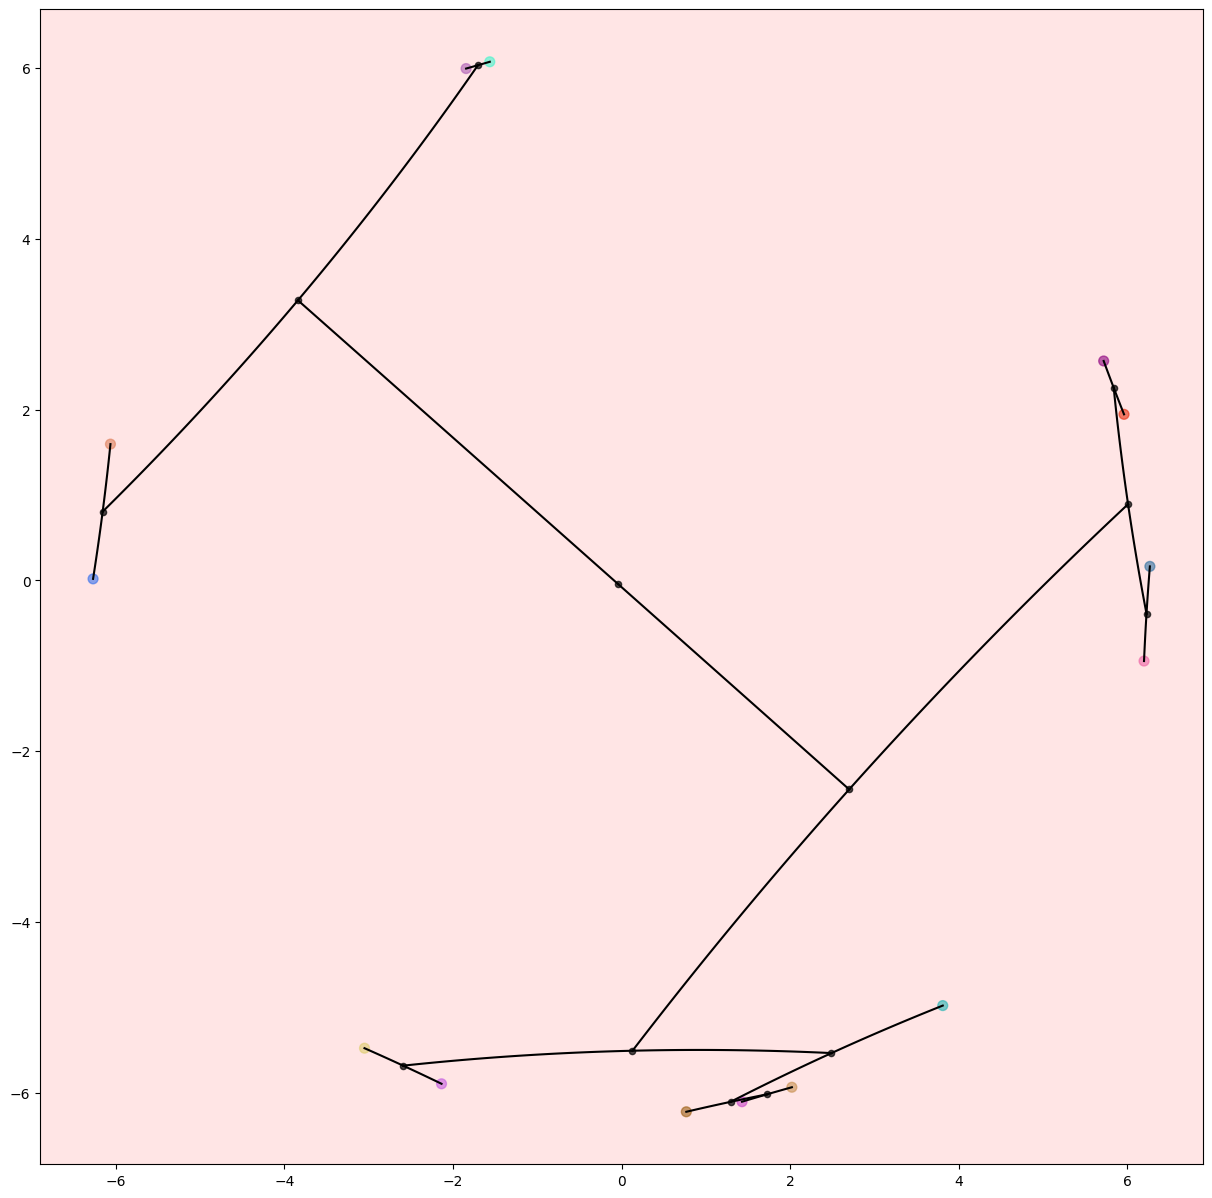

In [13]:
get_Hyper_tree(folder_path+'datas.data',1,tmp1.shape[1]+1,0,10,model_path=None,save_path=folder_path,c=0)


In [14]:
adata1.obs['leiden'].to_csv(folder_path+'leiden.csv')

In [20]:
nodes1,n1 = build_hyper_tree(folder_path)
show_tree(nodes1[0]).show_fig()
nodes2,n2 = build_hyper_tree('./datas/flip/')
show_tree(nodes2[0]).show_fig()
T=tree_alignment(nodes1[0],nodes2[0],1);
minn = T.run_alignment();
T.show_ans();
ans = T.get_ans()
G=show_graph(ans,nodes1[0],nodes2[0]);
G.show_fig()
print("average cost for one node:{}".format(minn/(n1+n2)))

The mininum cost for alignment is 28.651127819548872
The alignment edges list is [('26', '26'), ('25', '25'), ('20', '15'), ('12', '1'), ('3', '13'), ('14', '14'), ('4', '9'), ('2', '10'), ('24', '24'), ('23', '23'), ('22', '22'), ('17', '21'), ('15', '17'), ('9', '6'), ('1', '8'), ('7', '7'), ('11', '2'), ('18', '16'), ('10', '0'), ('6', '5'), ('21', '19'), ('0', '4'), ('5', '11')]


average cost for one node:0.5305764411027569
